In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns
import util

import cartopy.crs as ccrs

# Setup

In [8]:
from dask.distributed import Client, progress

if util.is_ncar_host():
    from dask_jobqueue import SLURMCluster
    cluster = SLURMCluster(project='UCGD0006')
    #from ncar_jobqueue import NCARCluster
    #cluster = NCARCluster(project='UCGD0006')
    cluster.adapt(minimum_jobs=1, maximum_jobs=40)
else:
    from dask_kubernetes import KubeCluster
    cluster = KubeCluster()
    cluster.adapt(minimum=1, maximum=40)
cluster

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [9]:
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.218:38860 Dashboard: http://128.117.181.218:45253/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Load data

In [10]:
import intake
import util

if util.is_ncar_host():
    print("On NCAR")
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    print("On GCP")
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

On NCAR


In [11]:
variable_id = 'tas'
institution_id = 'MIROC'
source_id = 'MIROC6'

cat = col.search(
    experiment_id=['piControl', 'historical', 'ssp585'],
    variable_id=variable_id,
    source_id=[source_id, ]
)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
530127,CMIP,MIROC,MIROC6,historical,r2i1p1f1,Amon,tas,gn,NaN,v20181212,185001-194912,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
530128,CMIP,MIROC,MIROC6,historical,r2i1p1f1,Amon,tas,gn,NaN,v20181212,195001-201412,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
530908,CMIP,MIROC,MIROC6,historical,r5i1p1f1,Amon,tas,gn,NaN,v20181212,185001-194912,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
530909,CMIP,MIROC,MIROC6,historical,r5i1p1f1,Amon,tas,gn,NaN,v20181212,195001-201412,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
531689,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,NaN,v20181212,185001-194912,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
531690,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,NaN,v20181212,195001-201412,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
532470,CMIP,MIROC,MIROC6,historical,r4i1p1f1,Amon,tas,gn,NaN,v20181212,185001-194912,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
532471,CMIP,MIROC,MIROC6,historical,r4i1p1f1,Amon,tas,gn,NaN,v20181212,195001-201412,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
533251,CMIP,MIROC,MIROC6,historical,r3i1p1f1,Amon,tas,gn,NaN,v20181212,195001-201412,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...
533252,CMIP,MIROC,MIROC6,historical,r3i1p1f1,Amon,tas,gn,NaN,v20181212,185001-194912,/glade/collections/cmip/CMIP6/CMIP/MIROC/MIROC...


In [ ]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 
                 'decode_times': True},
    cdf_kwargs={},
)
# list(dset_dict.keys())

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


In [ ]:
print("... we loaded!")

Go ahead and load in the data - we're going to seed our later analyses by pulling out re *piControl*, *historical*, and *ssp585* simulations. We do some very light pre-processing, too:

1. "Squeeze" any unit coords/dimensions.
2. Select a subset of the `Dataset` we loaded which only includes the variable of interest. This also helps clip out unneeded data.
3. Enforce decoding based on CF-Conventions.
4. Compute yearly means

In [ ]:
pi = f'CMIP.{institution_id}.{source_id}.piControl.Amon.gn'
hist =  f'CMIP.{institution_id}.{source_id}.historical.Amon.gn'
fut = f'ScenarioMIP.{institution_id}.{source_id}.ssp585.Amon.gn'

def _pre_process(ds, variable_id=variable_id):
    """ Some standard QoL to pre-process the data we pulled
    in from out catalog.
    
    """
    ds = ds.squeeze()
    ds = xr.decode_cf(ds)
    da = ds[variable_id]
    da = da.groupby('time.year').mean()
    return da

pi_ds = dset_dict[pi].pipe(_pre_process)
hist_ds = dset_dict[hist].pipe(_pre_process)
fut_ds = dset_dict[fut].pipe(_pre_process)

We've supplied a function `area_grid()` which consumes 1D vectors of longitudes and latitudes, and creates a 2D mesh of grid cell areas. We can use this with another supplied function, `global_avg()`, which really just does a weighted average:

$$T_\mathrm{global}(t) = \frac{\mathrm{Area}(\phi, \lambda, t) \cdot T(\phi, \lambda, t)}{\sum\limits_{(\phi,\lambda)}\mathrm{Area}(\phi, \lambda, t)}$$

In [ ]:
from tools import global_avg, area_grid

x = pi_ds.isel(year=0)
area = area_grid(x['lon'].data, x['lat'].data, asarray=False)

# We eagerly did the area grid calculation in memory, so let's
# turn it into a dask array now (inside a DataArray)
area = area.chunk()

In [ ]:
pi_ds_gavg = global_avg(pi_ds, weights=area)
hist_ds_gavg = global_avg(hist_ds, weights=area)
fut_ds_gavg = global_avg(fut_ds, weights=area)

We now want to take anomalies from the global average temperature some baseline. We'll create a simple transformer object to facilitate this.

In [ ]:
class BaselineAnomalizer(object):
    """ Transformer-like object for analyzing and removing
    a climatological baseline to compute anomaly timeseries. 
    
    """
    
    def __init__(self, time_dim, time_bnds):
        self.time_dim = time_dim
        self.time_bnds = time_bnds
        
        self._baseline_mean = None
        
    @property
    def baseline_mean(self):
        return self._baseline_mean
        
    @property
    def time_slice(self):
        return slice(*self.time_bnds)
    
    @property
    def indexer(self):
        return {self.time_dim: self.time_slice}
    
    @staticmethod
    def remove_baseline(data, baseline):
        return data - baseline
    
    def fit(self, X, y=None, mean_dims=[]):
        _mean_dims = [self.time_dim, ]
        if mean_dims:
            _mean_dims += mean_dims
        self._baseline_mean = (
            X.sel(**self.indexer).mean(_mean_dims)
        )
        
    def transform(self, X):
        if self._baseline_mean is None:
            raise ValueError("Must call 'fit' before 'transform'")
        return self.remove_baseline(X, self._baseline_mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [ ]:
baseline_anomalizer = BaselineAnomalizer('year', (1980, 2010))

x = hist_ds_gavg.mean('member_id')
baseline_anomalizer.fit(x)
xp = baseline_anomalizer.transform(x)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10.,5.))
ax = fig.add_axes([0.,0.,1.,1.])
line1, = xp.plot(c='r')
line2, = plt.plot(xp.year.values,np.zeros(len(xp.year.values)),c='k',ls='--')
plt.ylim(bottom=-0.6,top=0.6)
plt.xlabel('Years')
plt.ylabel('Anomaly')
plt.title('MIROC6 Air Temperature')
plt.grid(color='0.5', linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.,y=0.)
plt.legend([line1,line2],
          ["MIROC6",
           "Zero Anom"],
          loc="upper left",
          fancybox=True, fontsize=12, framealpha=0.8)
plt.show()
plt.savefig('/glade/u/home/molina/fig1.png')

## Create Dataset for analysis

Stitch together the historical and future warming scenarios - the ensemble mean of both. Go ahead and also create the corresponding global average time series.

In [ ]:
_hist_mean_ds = hist_ds.mean('member_id')
_fut_mean_ds = fut_ds.mean('member_id')

_modern_mean_ds = xr.combine_by_coords([
    _hist_mean_ds.to_dataset(name=variable_id), 
    _fut_mean_ds.to_dataset(name=variable_id)
])[variable_id]

# Sub-select data after 1950
_modern_mean_ds = _modern_mean_ds.sel(year=slice(1950, 2100))

# Eagerly load into cluster memory
_modern_mean_ds = _modern_mean_ds.persist()

In [ ]:
_modern_mean_gavg_ds = global_avg(_modern_mean_ds, weights=area)
_modern_mean_gavg_ds = _modern_mean_gavg_ds.persist()

Sanity check plot that our data makes sense...

In [ ]:
notkelvin = _modern_mean_gavg_ds-273.15


fig = plt.figure(figsize=(8.,5.))
ax = fig.add_axes([0.,0.,1.,1.])
line1, = notkelvin.plot(c='darkred',ls='-')
plt.xlabel('Years')
a = u"\u00b0"
plt.ylabel('Temperature '+'('+a+'C)')
plt.title('MIROC6 Air Temperature')
plt.grid(color='0.5', linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.,y=0.)
plt.legend([line1,],
          ["Historical and\nFuture Warming"],
          loc="upper left",
          fancybox=True, fontsize=12, framealpha=0.8)
plt.show()
plt.savefig('/glade/u/home/molina/fig2.png')

Remove a baseline (1980-2010) to compute anomalies. Note that we do this _separately_ for the global average timeseries and the noraml anomal data, since we want to localize the anomalies to the local climatology.

In [ ]:
baseline_anomalizer = BaselineAnomalizer('year', (1980, 2010))

# Compute anomalies
## 1) Global Avg
baseline_anomalizer.fit(_modern_mean_gavg_ds)
print(baseline_anomalizer.baseline_mean.compute())
_modern_mean_gavg_anom_ds = \
    baseline_anomalizer.transform(_modern_mean_gavg_ds)

## 2) Global timeseries
baseline_anomalizer.fit(_modern_mean_ds)
print(baseline_anomalizer.baseline_mean.compute())
_modern_mean_anom_ds = \
    baseline_anomalizer.transform(_modern_mean_ds)

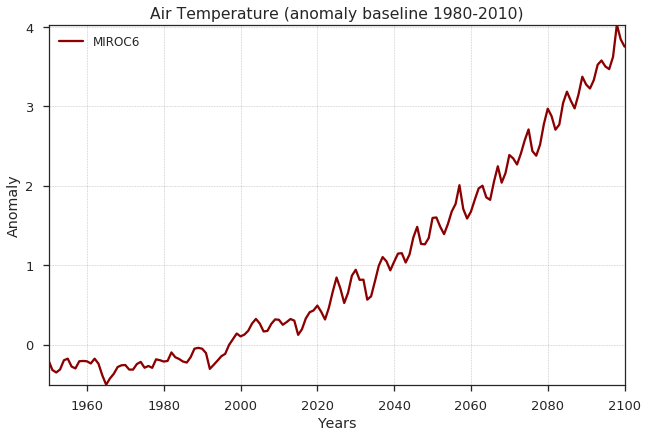

In [58]:
fig = plt.figure(figsize=(8.,5.))
ax = fig.add_axes([0.,0.,1.,1.])
line1, = _modern_mean_gavg_anom_ds.plot(c='darkred',ls='-')
plt.xlabel('Years')
a = u"\u00b0"
plt.ylabel('Anomaly')
plt.title('Air Temperature (anomaly baseline 1980-2010)')
plt.grid(color='0.5', linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.,y=0.)
plt.legend([line1,],
          ["MIROC6"],
          loc="upper left",
          fancybox=True, fontsize=12, framealpha=0.8)
#plt.show()
plt.savefig('/glade/u/home/molina/fig3.png')

## Calculate $\tilde{T}_\mathrm{global}$(t)

Fit a 4th-order polynomial to our global warming timeseries

In [59]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=4)

data = _modern_mean_gavg_anom_ds
y = data.values
x = data['year'].values

x = x[:, np.newaxis]
y = y[:, np.newaxis]

xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

glbl_ts = (
    _modern_mean_gavg_anom_ds
    .copy()
    .to_dataset(name=variable_id)
)
glbl_ts[f'{variable_id}_smoothed'] = (('year', ), ypred)

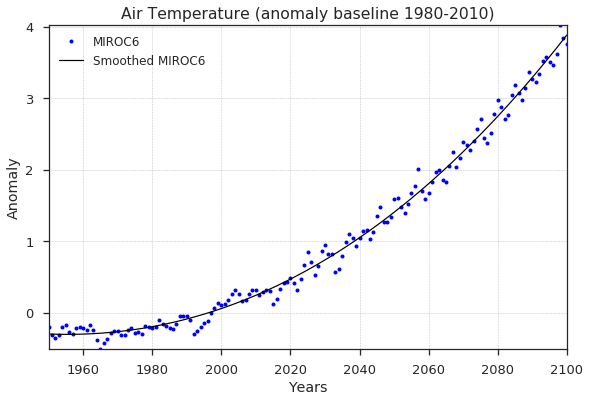

In [60]:
fig = plt.figure(figsize=(8.,5.))
ax = fig.add_axes([0.025,0.025,0.9,0.9])
scat1, = glbl_ts[variable_id].plot.line('bo', ms=4)
line1, = glbl_ts[variable_id+'_smoothed'].plot.line('k', lw=1.2)
plt.xlabel('Years')
a = u"\u00b0"
plt.ylabel('Anomaly')
plt.title('Air Temperature (anomaly baseline 1980-2010)')
plt.grid(color='0.5', linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.,y=0.)
plt.legend([scat1,line1,],
          ["MIROC6","Smoothed MIROC6"],
          loc="upper left",
          fancybox=True, fontsize=12, framealpha=0.8)
plt.savefig('/glade/u/home/molina/fig4.png', bbox_inches='tight')

![](/glade/u/home/molina/fig4.png)

## Compute regression coefficients $\alpha$, $\beta$

Now we need to regress the temperature in each grid cell against the global average. We begin with a simple example.

### Local testing

In [61]:
lon = 360. - 71.2
lat = 42

local_ts = _modern_mean_anom_ds.sel(
    lon=lon, lat=lat, method='nearest'
)

data = _modern_mean_gavg_anom_ds
y = local_ts.values
x = glbl_ts[variable_id].values

Statsmodels ...

In [62]:
_x = np.concatenate((x[:, None], np.ones_like(x[:, None])), 
                    axis=-1)
_y = y[:, np.newaxis]
print(_x.shape, _y.shape)

model = sm.OLS(_y, _x, hasconst=True).fit()
ypred = model.predict(_x)

local_ts_sm = local_ts.to_dataset(name=variable_id)
local_ts_sm[f'{variable_id}_projected'] = (('year', ), ypred)

(151, 2) (151, 1)


In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3777.
Date:                Fri, 18 Oct 2019   Prob (F-statistic):          9.47e-108
Time:                        12:18:39   Log-Likelihood:                -62.179
No. Observations:                 151   AIC:                             128.4
Df Residuals:                     149   BIC:                             134.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4640      0.024     61.457      0.000       1.417       1.511
const         -0.0139      0.038     -0.362      0.718      -0.090       0.062
==============================================================================
Omnibus:                        6.803   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.425
Skew:                          -0.344   Prob(JB):                       0.0244
Kurtosis:                       3.840   Cond. No.                         2.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

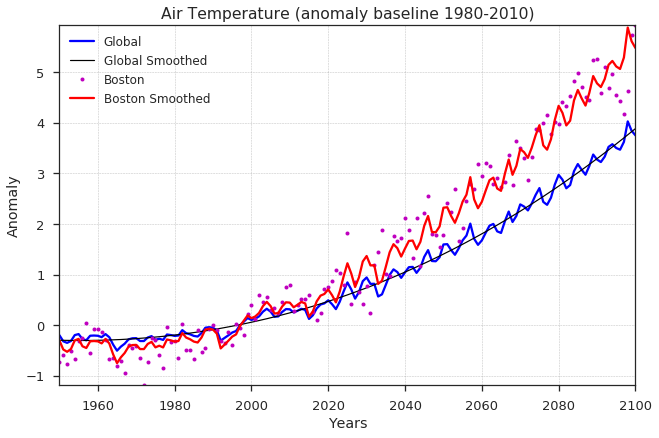

In [64]:
fig = plt.figure(figsize=(8.,5.))
ax = fig.add_axes([0.,0.,1.,1.])


line1, = glbl_ts[variable_id].plot.line('b', ms=4)
line2, = glbl_ts[variable_id+'_smoothed'].plot.line('k', label='global', lw=1.2)
line3, = local_ts_sm[variable_id].plot.line('mo', ms=4)
line4, = local_ts_sm[variable_id+'_projected'].plot.line('r', label='projected')

#line1, = glbl_ts[variable_id+'_smoothed'].plot.line('k', lw=1.2)
plt.xlabel('Years')
a = u"\u00b0"
plt.ylabel('Anomaly')
plt.title('Air Temperature (anomaly baseline 1980-2010)')
plt.grid(color='0.5', linestyle='--', linewidth=0.5, alpha=0.5)
plt.margins(x=0.,y=0.)
plt.legend([line1,line2,line3,line4],
          ["Global","Global Smoothed",
           "Boston","Boston Smoothed"],
          loc="upper left",
          fancybox=True, fontsize=12, framealpha=0.8)
plt.savefig('/glade/u/home/molina/fig5.png', bbox_inches='tight')
#plt.show()

Scikit-learn

In [65]:
from sklearn.linear_model import LinearRegression

_x = x[:, None]
_y = y[:]

regr = LinearRegression()
regr.fit(_x, _y)
print(f'Coefficients: {regr.coef_}')
print(f'Intercept: {regr.intercept_}')

ypred = regr.predict(_x)

local_ts_skl = local_ts.to_dataset(name=variable_id)
local_ts_skl[f'{variable_id}_projected'] = (('year', ), ypred)

Coefficients: [1.46402811]
Intercept: -0.013850538758806596


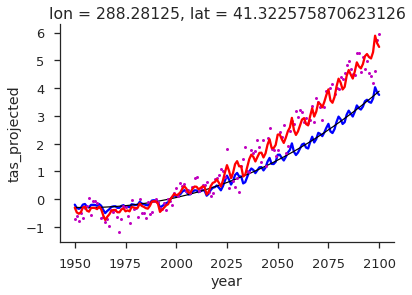

In [66]:
glbl_ts[variable_id].plot.line('b', ms=3)
glbl_ts[variable_id+'_smoothed'].plot.line('k', label='global', lw=1.2)

local_ts_sm[variable_id].plot.line('mo', ms=3)
local_ts_sm[variable_id+'_projected'].plot.line('r', label='projected')

ax = plt.gca()
sns.despine(ax=ax)

Numpy

In [67]:
class PolyFit(object):
    
    def __init__(self, degree=1):
        self.degree = degree
        self._p = []
    
    @property
    def p(self):
        return self._p
    
    @staticmethod
    def poly_calc(x, p):
        y_hat = 0
        for i, pi in enumerate(reversed(p)):
            y_hat += x**i * pi
        return y_hat
    
    def fit(self, X, y=None):
        p = np.polyfit(X, y, self.degree)
        self._p = p
        
    def predict(self, X):
        return self.poly_calc(X, self._p)

In [68]:
_x = x[:]
_y = y[:]

pf = PolyFit(degree=1)
pf.fit(_x, _y)
print(f'Params: {pf.p}')

ypred = pf.predict(_x)

local_ts_pf = local_ts.to_dataset(name=variable_id)
local_ts_pf[f'{variable_id}_projected'] = (('year', ), ypred)

Params: [ 1.46402811 -0.01385054]


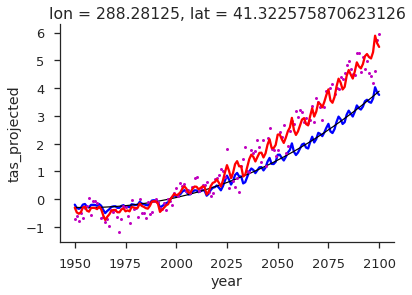

In [69]:
glbl_ts[variable_id].plot.line('b', ms=3)
glbl_ts[variable_id+'_smoothed'].plot.line('k', label='global', lw=1.2)

local_ts_sm[variable_id].plot.line('mo', ms=3)
local_ts_sm[variable_id+'_projected'].plot.line('r', label='projected')

ax = plt.gca()
sns.despine(ax=ax)

### Global Distribution

Now we need a mechanism to apply this calculation to every grid cell.

Closely related to [this GH Issue](https://github.com/pydata/xarray/issues/3349).

Our simplest, easiest way of doing this is just to stack the data to obey the format of `polyfit` and run with that.

In [70]:
stacked = _modern_mean_anom_ds.stack(cell=['lon', 'lat'])
print(stacked.data.shape)

x = glbl_ts[variable_id+'_smoothed'].data
y = stacked.data
print(x.shape, y.shape)

p = np.polyfit(x, y, 1)
print(p.shape)
alphas, betas = p
print(alphas.shape, betas.shape)

(151, 32768)
(151,) (151, 32768)
(2, 32768)
(32768,) (32768,)


In [71]:
stacked['α'] = (['cell', ], alphas)
stacked['β'] = (['cell', ], betas)
fitted = stacked.unstack('cell')

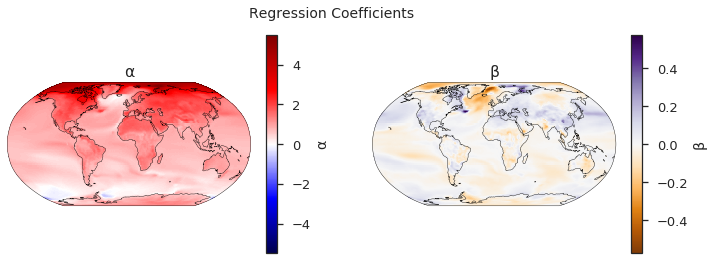

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12.,4.), 
                        subplot_kw={'projection': ccrs.Robinson(),
                                    'aspect': 'auto'})

plt.suptitle('Regression Coefficients', fontsize=14)

fitted.α.plot.imshow('lon', 'lat', ax=axs[0], transform=ccrs.PlateCarree(), cmap='seismic')
fitted.β.plot.imshow('lon', 'lat', ax=axs[1], transform=ccrs.PlateCarree(), cmap='PuOr')

titles=['α','β']

for ax, title in zip(axs, titles):
    ax.coastlines()
    ax.set_title(title)
    ax.set_aspect('equal', 'box')
    
plt.savefig('/glade/u/home/molina/fig6.png', )

## Project to calculate $S(t)$

Project future temperatures using the fitted model

In [34]:
def S(year, glbl_temp=glbl_ts[f'{variable_id}_smoothed'], 
      α=fitted.α, β=fitted.β):
    return α*glbl_temp.sel(year=year) + β

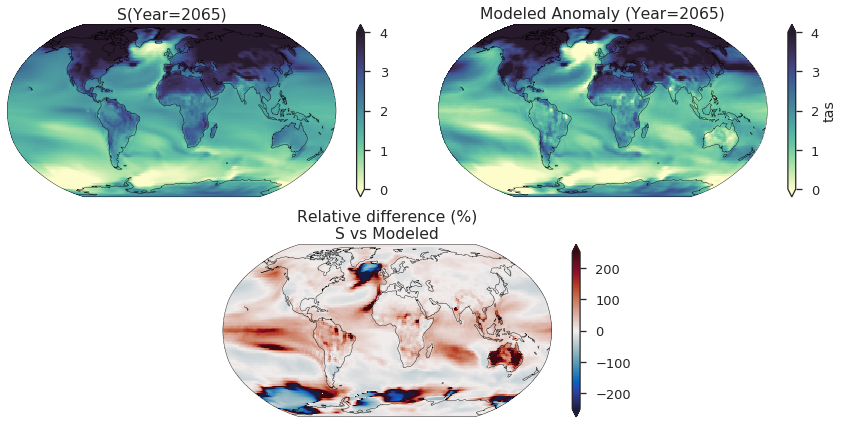

In [35]:
import cartopy.crs as ccrs
import cmocean
from matplotlib.gridspec import GridSpec

from tools import shift_lons

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 4)
subplot_kw = dict(projection=ccrs.Robinson(), aspect='auto')

axl = fig.add_subplot(gs[0, 0:2], **subplot_kw)
axc = fig.add_subplot(gs[1, 1:3], **subplot_kw)
axr = fig.add_subplot(gs[0, 2:], **subplot_kw)
axs = [axl, axc, axr]

year = 2065

# predicted = \
#     fitted.α*glbl_ts[f'{variable_id}_smoothed'].sel(year=year) 
# predicted += fitted.β
predicted = S(year)

actual = _modern_mean_anom_ds.sel(year=year)
diff = 100*(predicted - actual)/actual

cmap_kws = dict(vmin=0, vmax=4, cmap=cmocean.cm.deep)

im1 = predicted.plot.imshow('lon', 'lat', ax=axl, transform=ccrs.PlateCarree(),**cmap_kws)

axl.set_title("S(Year={})".format(year))
actual.plot.imshow('lon', 'lat', ax=axr, transform=ccrs.PlateCarree(),
                   **cmap_kws)

axr.set_title("Modeled Anomaly (Year={})".format(year))

cmap_kws = dict(vmin=-250, vmax=250, cmap=cmocean.cm.balance)

diff.plot.imshow('lon', 'lat', ax=axc, transform=ccrs.PlateCarree(),
                 **cmap_kws)

axc.set_title("Relative difference (%)\nS vs Modeled")

for ax in axs:
    ax.coastlines()
    ax.set_aspect('auto', 'box')
    
plt.tight_layout()
plt.savefig('/glade/u/home/molina/fig7.png')

## Calculate $N$

The second half of this analysis task involves computing the $N$ or "noise" term. Hawkins and Sutton are pretty standard here; they simply take the inter-annual standard deviation of whatever unit means we have in our dataset (here, annual means). They do seek to retain the spatial pattern in the interannual variability.

Text(0.5, 0, 'Year')

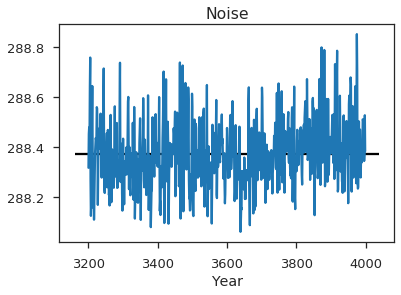

In [36]:
x_ts = pi_ds_gavg.persist()
x_ts.plot.line()
plt.hlines(x_ts.mean('year'), *plt.xlim())
plt.title("Noise")
plt.xlabel("Year")

In [37]:
pi_demean = pi_ds - x_ts.mean()

In [38]:
N = pi_demean.std('year')
N = N.persist()

Text(0, 0.5, 'Latitude')

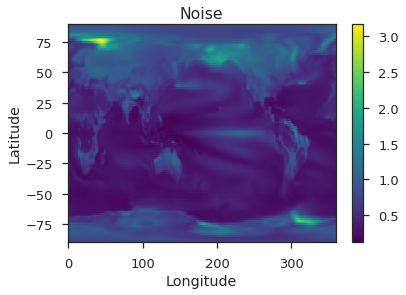

In [39]:
N.plot.imshow('lon', 'lat')
plt.title('Noise')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Putting it all together...

Now we can tie the two together. First we need to create a timeseries of $S(t)$. We can then scale it by $N$, and look at statistics.

In [147]:
years = range(2020, 2101)
signal = S(years)

sn_ds = N.to_dataset(name='N')
sn_ds['year'] = (('year', ), years)
sn_ds['S'] = (signal.dims, signal)
sn_ds['S_N'] = sn_ds['S'] / sn_ds['N']

sn_ds = sn_ds.persist()

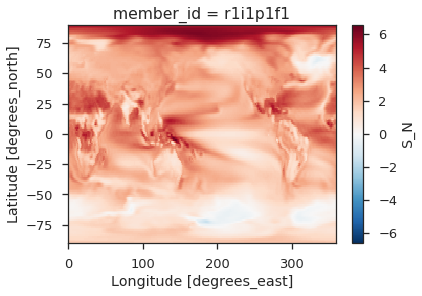

In [150]:
(sn_ds['S_N']
 .sel(year=slice(2030, 2050))
 .mean('year')
 .plot.imshow('lon', 'lat')
)

## Calculate ToE

The easiest way to calculate the year of emergence is just to loop over the time index of the data and record whenever the values in each grid cell are larger than a given threshold.

In [153]:
import pandas as pd

template = sn_ds['S'].isel(year=0).data
toe_s = np.zeros_like(template)

toe_das = []
ratios = 1, 2, 3
for ratio in ratios:
    toe_s = np.zeros_like(template)
    for year in sn_ds.year:
        _sn_year = sn_ds['S_N'].sel(year=year).data
        toe_s[(toe_s == 0) & (_sn_year > ratio)] = year
        
    # Mask out zeros
    toe_s = np.ma.masked_equal(toe_s, 0)
    toe_da = xr.DataArray(toe_s, 
                          dims=['lon', 'lat'], 
                          coords=[sn_ds.lon, sn_ds.lat])
    toe_das.append(toe_da)

toe_ds = xr.concat(toe_das, dim=pd.Index(ratios, name='ratio'))
toe_ds.name = 'TOE'
sn_ds['TOE'] = toe_ds

Maps of time of emergence

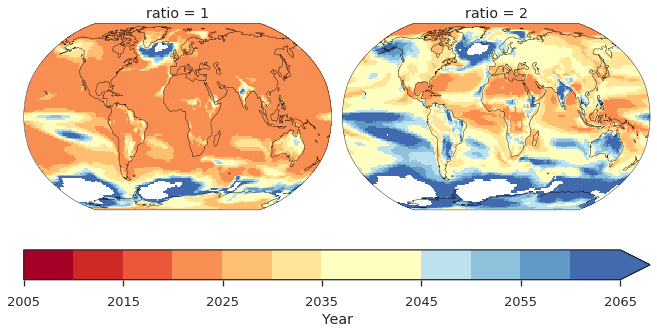

In [162]:
nrows, ncols = 1, 2
size, aspect = 4., 1.
width, height = size*aspect*ncols, size*nrows
figsize = (width, height)

g = sn_ds['TOE'].sel(ratio=[1, 2]).plot.imshow(
    x='lon', y='lat', col='ratio',
    vmin=2005, vmax=2065, extend='max', levels=13,
    cmap="RdYlBu",
    aspect=aspect, size=size,
    subplot_kws=dict(projection=ccrs.Robinson(),
                     aspect='auto'),
    cbar_kwargs=dict(orientation='horizontal',
                     label='Year'),
    transform=ccrs.PlateCarree()
)
for ax in g.axes.ravel():
    ax.coastlines()
    ax.set_aspect('auto', 'box')